In [ ]:
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 11 00:23:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import tensorflow as tf

import tensorflow_privacy as tfp
import tensorflow_federated as tff

import collections
import io
import os
import pandas as pd
import requests
import tempfile
import zipfile
import pickle
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from tensorflow_privacy.privacy.analysis import dp_event
from tensorflow_privacy.privacy.dp_query import dp_query
from tensorflow_privacy.privacy.dp_query import normalized_query

from tensorflow_federated.python.aggregators import concat
from tensorflow_federated.python.aggregators import differential_privacy
#from tensorflow_federated.python.aggregators import discretization
from tensorflow_federated.python.aggregators import factory
#from tensorflow_federated.python.aggregators import modular_clipping
from tensorflow_federated.python.aggregators import quantile_estimation
from tensorflow_federated.python.aggregators import robust
from tensorflow_federated.python.aggregators import rotation
from tensorflow_federated.python.aggregators import secure
from tensorflow_federated.python.aggregators.mean import UnweightedMeanFactory

Mounted at /content/drive


In [ ]:
# Experiment parameters

cohort_size = 40
#model_architecture = 'simple'
model_architecture = '1m_cnn'
l2_clip_norm = 0.03

# PBM parameters
local_counts = 200
scaling_factor = 0.15

dump_file_dir = '/content/drive/MyDrive/colab_dump/'

# PBM query

In [ ]:
"""Implements DPQuery interface for Skellam average queries."""

class DistributedPoissonBinomialSumQuery(dp_query.SumAggregationDPQuery):

  _GlobalState = collections.namedtuple(
      '_GlobalState', ['max_norm_bound', 'local_counts', 'scaling_factor'])

  _SampleParams = collections.namedtuple(
      '_SampleParams', ['max_norm_bound', 'local_counts', 'scaling_factor'])

  def __init__(self, max_norm_bound, local_counts, scaling_factor):
    """Initializes the DistributedPoissonBinomialSumQuery.

    Args:
      max_norm_bound: The l_inf norm bound to verify for each record.
      local_counts: The l2 norm bound to verify for each record.
      scaling_factor: The standard deviation of the Skellam distribution.
    """
    self._max_norm_bound = max_norm_bound
    self._local_counts = local_counts
    self._scaling_factor = scaling_factor

  def initial_global_state(self):
    return self._GlobalState(
        tf.cast(self._max_norm_bound, tf.float32),
        tf.cast(self._local_counts, tf.int32),
        tf.cast(self._scaling_factor, tf.float32))

  def derive_sample_params(self, global_state):
    return self._SampleParams(global_state.max_norm_bound,
                              global_state.local_counts,
                              global_state.scaling_factor)
  
  def preprocess_record(self, params, record):
    """Clip record norm and add noise to the record.

    Args:
      params: The parameters for the particular sample.
      record: The record to be processed.

    Returns:
      A tuple (preprocessed_records, params) where `preprocessed_records` is
        the structure of preprocessed tensors, and params contains sample
        params.
    """ 
    record_as_list = tf.nest.flatten(record)
    tf.nest.map_structure(lambda x: tf.debugging.assert_type(x, tf.float32),
                          record_as_list)
    
    def max_norm_clip(v):
      return tf.clip_by_value(v, clip_value_min = -1*params.max_norm_bound, 
                                clip_value_max = params.max_norm_bound, name=None)

    record_clipped = tf.nest.map_structure(max_norm_clip, record)
    record_to_prob = record_clipped/params.max_norm_bound*params.scaling_factor+0.5
    binomial = tf.random.stateless_binomial(
          shape=tf.shape(record),
          seed=tf.cast([tf.timestamp() * 10**6, 0], tf.int64),
          counts=[params.local_counts],
          probs=record_to_prob,
          output_dtype=tf.float32)
    return binomial-0.5*tf.cast(params.local_counts, tf.float32)
    #return binomial

  def get_noised_result(self, sample_state, global_state):
    """The noise was already added locally, therefore just continue."""
    def estimate(v):
      return v/tf.cast(global_state.local_counts, tf.float32)/global_state.scaling_factor*global_state.max_norm_bound 
    result = tf.nest.map_structure(estimate, sample_state)
    event = dp_event.UnsupportedDpEvent()
    return result, global_state, event


In [ ]:
# Test PBM
tensor = tf.constant([2, 0, 3], dtype=tf.float32)
record = tensor

query = DistributedPoissonBinomialSumQuery(
    max_norm_bound=2, local_counts=2000, scaling_factor=0.15)
global_state = query.initial_global_state()
sample_params = query.derive_sample_params(global_state)
sample_state = query.initial_sample_state(template = record)

print(sample_state)
sample_state = query.accumulate_record(
        sample_params, sample_state, record)
print(sample_state)

result, global_state, _ = query.get_noised_result(
      sample_state, global_state)
print(result)

tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([269.   0. 322.], shape=(3,), dtype=float32)
tf.Tensor([1.7933332 0.        2.1466665], shape=(3,), dtype=float32)


# Loading emnist data/create models

## Loading data

In [ ]:
# Simplify this cell with tff.simulation.baselines.emnist something.
def get_emnist_idataset():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=False)

  def element_fn(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
    return (dataset.map(element_fn)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(preprocess_train_dataset)
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test

train_data, test_data = get_emnist_idataset()

## Create Models

In [ ]:
def create_1m_cnn_model(only_digits: bool = False):
  data_format = 'channels_last'
  initializer = tf.keras.initializers.GlorotUniform()

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(
          32,
          kernel_size=(3, 3),
          activation='relu',
          data_format=data_format,
          input_shape=(28, 28, 1),
          kernel_initializer=initializer),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format=data_format),
      tf.keras.layers.Conv2D(
          64,
          kernel_size=(3, 3),
          activation='relu',
          data_format=data_format,
          kernel_initializer=initializer),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          128, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(
          10 if only_digits else 62,
          activation=tf.nn.softmax,
          kernel_initializer=initializer),
  ])
  return model

def create_simple_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(62, activation=tf.nn.softmax)])

def my_model_fn():
  return tff.learning.from_keras_model(
      keras_model=create_1m_cnn_model(),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

def my_simple_model_fn():
  return tff.learning.from_keras_model(
      keras_model=create_simple_keras_model(),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## Centralized Gaussian mechanism

For now, as a benchark, we only clip the l2 norm of gradients.

In [ ]:
factory = robust.clipping_factory(clipping_norm=l2_clip_norm, inner_agg_factory=UnweightedMeanFactory())
factory = rotation.HadamardTransformFactory(inner_agg_factory=factory)
factory = concat.concat_factory(inner_agg_factory=factory)

if model_architecture == 'simple':
  learning_process = tff.learning.build_federated_averaging_process(
    my_simple_model_fn, lambda: tf.keras.optimizers.SGD(0.01),
    model_update_aggregation_factory=factory)
  eval_fn = tff.learning.build_federated_evaluation(my_simple_model_fn)

else:
  learning_process = tff.learning.build_federated_averaging_process(
    my_model_fn, lambda: tf.keras.optimizers.SGD(0.01),
    model_update_aggregation_factory=factory)
  eval_fn = tff.learning.build_federated_evaluation(my_model_fn)

def print_eval_metrics(metrics, i):
  print(f'Round {i:3d} \t'
        f'Accuracy: {metrics["eval"]["sparse_categorical_accuracy"]:.4} \t'
        f'Loss: {metrics["eval"]["loss"]:.4}')
  
def print_train_metrics(metrics, i):
  print(f'Round {i:3d} \t'
        f'Max client not close zero:  \t'
        f'Server not close zero: ')

print(f'Starting training...')
state = learning_process.initialize()

central_clip_train_metrics_list = []
central_clip_eval_metrics_list = []
# Training loop.
for i in range(100):
  if i % 3 == 0:
    print_eval_metrics(eval_fn(state.model, [test_data]), i)

  # Sample clients for a round.
  sampled_clients = np.random.choice(
      train_data.client_ids,
      size=cohort_size,
      replace=False)
  sampled_train_data = [
      train_data.create_tf_dataset_for_client(client)
      for client in sampled_clients]

  # Round of training.
  state, metrics = learning_process.next(state, sampled_train_data)
  central_clip_train_metrics_list.append(metrics)
  central_clip_eval_metrics_list.append(eval_fn(state.model, [test_data]))

print_eval_metrics(eval_fn(state.model, [test_data]), i+1)

Starting training...


KeyboardInterrupt: ignored

## Poisson binomial mechanism

In [ ]:
# Determine gradient dimension
if model_architecture == 'simple':
  model = create_simple_keras_model()
else: 
  model = create_1m_cnn_model()

model_dim = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
max_norm_bound = l2_clip_norm/np.sqrt(model_dim)

print("l2_clip_norm: ", l2_clip_norm)
print("cohort_size: ", cohort_size)
print("Model dim: ", model_dim)
print("Max_norm_bound:", max_norm_bound)
print('Local counts:', local_counts)
print('Scaling factor:', scaling_factor)
print('Model architecture:', model_architecture)

dump_file_name = f'pbm_cohort_{cohort_size}_counts_{local_counts}_theta_{int(100*scaling_factor):03d}_clip_{int(100*l2_clip_norm):03d}'
dump_file_name = dump_file_name + '_' + model_architecture

print('Training metrics stored at')
print('/content/drive/MyDrive/colab_dump/'+dump_file_name+'_train_metrics_list.pickle')
print('Evaluationa metrics stored at')
print('/content/drive/MyDrive/colab_dump/'+dump_file_name+'_eval_metrics_list.pickle')

# Build a pbm factory
pbm_query = DistributedPoissonBinomialSumQuery(
    max_norm_bound=max_norm_bound, local_counts=local_counts, scaling_factor=scaling_factor)

factory = differential_privacy.DifferentiallyPrivateFactory(
   query=pbm_query, record_aggregation_factory=tff.aggregators.UnweightedMeanFactory())

# Build concat/rontation factory
#factory = robust.clipping_factory(clipping_norm=2., inner_agg_factory=factory)
factory = rotation.HadamardTransformFactory(inner_agg_factory=factory)
factory = concat.concat_factory(inner_agg_factory=factory)

if model_architecture == 'simple':
  learning_process = tff.learning.build_federated_averaging_process(
    my_simple_model_fn, lambda: tf.keras.optimizers.SGD(0.01),
    model_update_aggregation_factory=factory)
  eval_fn = tff.learning.build_federated_evaluation(my_simple_model_fn)

else:
  learning_process = tff.learning.build_federated_averaging_process(
    my_model_fn, lambda: tf.keras.optimizers.SGD(0.01),
    model_update_aggregation_factory=factory)
  eval_fn = tff.learning.build_federated_evaluation(my_model_fn)

def print_eval_metrics(metrics, i):
  print(f'Round {i:3d} \t'
        f'Accuracy: {metrics["eval"]["sparse_categorical_accuracy"]:.4} \t'
        f'Loss: {metrics["eval"]["loss"]:.4}')
  
def print_train_metrics(metrics, i):
  print(f'Round {i:3d} \t'
        f'Max client not close zero:  \t'
        f'Server not close zero: ')

print(f'Starting training...')
state = learning_process.initialize()

pbm_train_metrics_list = []
pbm_eval_metrics_list = []

# Training loop.
for i in range(800):
  if i % 3 == 0:
    print_eval_metrics(eval_fn(state.model, [test_data]), i)

  # Sample clients for a round.
  sampled_clients = np.random.choice(
      train_data.client_ids,
      size=cohort_size,
      replace=False)
  sampled_train_data = [
      train_data.create_tf_dataset_for_client(client)
      for client in sampled_clients]

  # Round of training.
  state, metrics = learning_process.next(state, sampled_train_data)

  # Dump metrics
  pbm_train_metrics_list.append(metrics)
  pbm_eval_metrics_list.append(eval_fn(state.model, [test_data]))
  if i % 50 == 1:
    with open(dump_file_dir + dump_file_name + '_train_metrics_list.pickle', 'wb') as handle:
      pickle.dump(pbm_train_metrics_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(dump_file_dir + dump_file_name + '_eval_metrics_list.pickle', 'wb') as handle:
      pickle.dump(pbm_eval_metrics_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
print_eval_metrics(eval_fn(state.model, [test_data]), i+1)


#####
# Plot results
def smooth(x, N):
    L = len(x)
    x_smooth = []
    for i in range(L):
      l = max(0, i-N/2)
      u = min(L-1, i+N/2)
      x_smooth.append(np.mean(x[int(l):int(u)]))
    return x_smooth

train_acc = [metrics["train"]["sparse_categorical_accuracy"] for metrics in pbm_train_metrics_list]
plt.plot(smooth(train_acc, 10))
eval_acc = [metrics["eval"]["sparse_categorical_accuracy"] for metrics in pbm_eval_metrics_list]
plt.plot(smooth(eval_acc, 10))
#plt.plot([metrics["train"]["sparse_categorical_accuracy"] for metrics in metrics_list])
plt.title('FMNIST')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

l2_clip_norm:  0.03
cohort_size:  40
Model dim:  1018174
Max_norm_bound: 2.9731050415169696e-05
Local counts: 200
Scaling factor: 0.15
Model architecture: 1m_cnn
Training metrics stored at
/content/drive/MyDrive/colab_dump/pbm_cohort_40_counts_200_theta_015_clip_003_1m_cnn_train_metrics_list.pickle
Evaluationa metrics stored at
/content/drive/MyDrive/colab_dump/pbm_cohort_40_counts_200_theta_015_clip_003_1m_cnn_eval_metrics_list.pickle
Starting training...
Round   0 	Accuracy: 0.03356 	Loss: 4.126
Round   3 	Accuracy: 0.03318 	Loss: 4.103
Round   6 	Accuracy: 0.03531 	Loss: 4.08
Round   9 	Accuracy: 0.06318 	Loss: 4.053
Round  12 	Accuracy: 0.04854 	Loss: 4.026
Round  15 	Accuracy: 0.04694 	Loss: 3.997
Round  18 	Accuracy: 0.047 	Loss: 3.968
Round  21 	Accuracy: 0.047 	Loss: 3.941
Round  24 	Accuracy: 0.047 	Loss: 3.915
Round  27 	Accuracy: 0.047 	Loss: 3.891
Round  30 	Accuracy: 0.047 	Loss: 3.874
Round  33 	Accuracy: 0.047 	Loss: 3.86
Round  36 	Accuracy: 0.047 	Loss: 3.846
Round  39

## Plot results

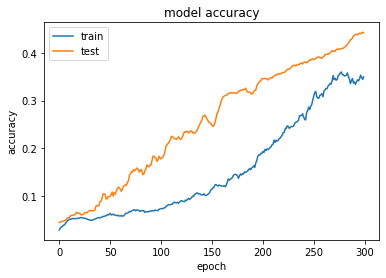

In [ ]:
train_acc = [metrics["train"]["sparse_categorical_accuracy"] for metrics in pbm_train_metrics_list]
plt.plot(smooth(train_acc, 10))
eval_acc = [metrics["eval"]["sparse_categorical_accuracy"] for metrics in pbm_eval_metrics_list]
plt.plot(smooth(eval_acc, 10))
#plt.plot([metrics["train"]["sparse_categorical_accuracy"] for metrics in metrics_list])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()